## Importing libraries

In [157]:
import re
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from itertools import combinations

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score

import warnings
warnings.filterwarnings('ignore')

### Extracting date time, contact-name, and message from the chat logs

In [158]:
def date_time(s):
    pattern = '^([0-9]+(\/)([0-9]+)(\/)[0-9]+, ([0-9]+):([0-9]+)\s(PM|AM|am|pm) - )'
    result = re.match(pattern, s)
    if result:
        return True 
    return False

def contact(s):
    s=s.split(":")
    if len(s) == 2:
        return True 
    return False

def getmsg(line):
    splitline = line.split(' - ')
    date, time = splitline[0].split(', ')
    msg = " ".join(splitline[1:])
   
    if contact(msg):
        split_msg = msg.split(': ')
        author = split_msg[0]
        msg = " ".join(split_msg[1:])
    else:
        author = None
    return date, time, author, msg


In [159]:
data = []
conversation = 'F:\\vs code\\nlp class\\Updated_chat_data.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    msgBuffer = []
    date, time, author=None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()

        if date_time(line):
            if len(msgBuffer) > 0 :
                data.append([date, time, author, " ".join(msgBuffer)])
            msgBuffer.clear()
            date, time, author, msg = getmsg(line)
            msgBuffer.append(msg)
        else:
            msgBuffer.append(line)

In [160]:
msgBuffer

['Days*', '', '']

### Converting the extracted data into DataFrame

In [161]:
data = pd.DataFrame(data, columns=["Date", "Time", "Contact", "Message"])
data['Date'] = pd.to_datetime(data['Date'])
data = data.dropna()
data

,Date,Time,Contact,Message
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year
1,2020-05-02,10:01 am,Ed,<Media omitted>
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣
3,2020-05-02,10:01 am,Rohit,💪🏾
4,2020-05-02,10:01 am,Rohit,yeah
...,...,...,...,...
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?
4692,2020-09-21,2:25 pm,Ed,You deleted this message
4693,2020-09-21,2:26 pm,Ed,<Media omitted>
4694,2020-09-21,2:26 pm,Rohit,onz onz


## Cleaning the Data

In [162]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

### Cleaning the deleted messages and media ommitio logs


In [163]:
data["Message"] = data['Message'][data["Message"] != "<Media omitted>"]
data.dropna(axis=0, inplace=True)

string_to_match = " deleted this message"
data = data[~data["Message"].str.contains(string_to_match, case=False)]
data


,Date,Time,Contact,Message
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣
3,2020-05-02,10:01 am,Rohit,💪🏾
4,2020-05-02,10:01 am,Rohit,yeah
6,2020-05-02,12:22 pm,Ed,Guys? Haha
...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message
4690,2020-09-20,1:06 pm,Ed,😂 😂
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?
4694,2020-09-21,2:26 pm,Rohit,onz onz


### Cleaning the messages from punctuations and stopwords and tokenized the messages

In [164]:
# Define a function to remove special characters
def remove_special_characters(text):
    # Use regex to remove special characters and emojis
    clean_text = re.sub(r'[^\w\s]','', text)
    return clean_text

# Apply the remove_special_characters function to the 'message' column
data['Cleaned_message'] = data["Message"].apply(remove_special_characters)

In [165]:


data['Tokenized_words'] = data["Cleaned_message"].apply(lambda y: [word for word in word_tokenize(y) if word not in STOPWORDS and word not in stop_words] )

In [166]:
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]"
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]"
3,2020-05-02,10:01 am,Rohit,💪🏾,,[]
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah]
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]"
...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]"
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[]
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]"
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]"


### Applying the lemmatization techniques

In [167]:
lemmatizer = WordNetLemmatizer()
data["Lemmatized"] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in data["Tokenized_words"]]


## Sentiment analysis

### Sentiments of each message

In [168]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

data['Positive'] = [sentiments.polarity_scores(i)['pos'] for i in data["Message"]]
data['Negative'] = [sentiments.polarity_scores(i)['neg'] for i in data["Message"]]
data['Neutral'] = [sentiments.polarity_scores(i)['neu'] for i in data["Message"]]

### Normalizing the values of the sentiment Analyzer

In [169]:
data["Positive"] = data["Positive"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))
data["Negative"] = data["Negative"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))
data["Neutral"] = data["Neutral"].apply(lambda x: np.ceil(x) if x - np.floor(x) >= 0.5 else np.floor(x))


In [170]:
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]","[We, share, knowledge, pas, year]",0.0,0.0,1.0
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]","[Easy, communicate]",0.0,0.0,1.0
3,2020-05-02,10:01 am,Rohit,💪🏾,,[],[],0.0,0.0,1.0
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah],[yeah],1.0,0.0,0.0
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]","[Guys, Haha]",1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]","[I, censor, message]",0.0,0.0,1.0
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[],[],0.0,0.0,0.0
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]","[finish, math, lecture]",0.0,0.0,1.0
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]","[onz, onz]",0.0,0.0,1.0


### Over all sentiment of the chat

In [171]:
pos = sum(data['Positive'])
neg = sum(data['Negative'])
neu = sum(data['Neutral'])

def score(a,b,c):
    if a>b and a>c:
        print('postive')
    elif b>a and b>c:
        print('negative')
    else:
        print("neutral")

score(pos, neg, neu)

pos, neg, neu

neutral


(419.0, 248.0, 3460.0)

### Added the sentiment in text form

In [172]:
def compare_values(row):
    if row['Positive'] > row['Negative'] and row['Positive'] > row['Neutral']:
        return 'positive'
    elif row['Negative'] > row['Positive'] and row['Negative'] > row['Neutral']:
        return 'negative'
    else:
        return 'neutral'

In [173]:
data["sentiment"] = data.apply(compare_values, axis = 1)
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]","[We, share, knowledge, pas, year]",0.0,0.0,1.0,neutral
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]","[Easy, communicate]",0.0,0.0,1.0,neutral
3,2020-05-02,10:01 am,Rohit,💪🏾,,[],[],0.0,0.0,1.0,neutral
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah],[yeah],1.0,0.0,0.0,positive
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]","[Guys, Haha]",1.0,0.0,0.0,positive
...,...,...,...,...,...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]","[I, censor, message]",0.0,0.0,1.0,neutral
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[],[],0.0,0.0,0.0,neutral
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]","[finish, math, lecture]",0.0,0.0,1.0,neutral
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]","[onz, onz]",0.0,0.0,1.0,neutral


### Extracting the sentiment trends into seperate dataframe

In [174]:
grouped = data.groupby('Date')

def most_common_sentiment(series):
    return Counter(series).most_common(1)[0][0]

# Create a new DataFrame with the required columns
sentiment_logs = grouped.agg(
    start_sentiment=('sentiment', 'first'),
    end_sentiment=('sentiment', 'last'),
    most_common_sentiment=('sentiment', most_common_sentiment)
).reset_index()

# Print the result DataFrame
print(sentiment_logs)

         Date start_sentiment end_sentiment most_common_sentiment
0  2020-01-07        positive       neutral               neutral
1  2020-01-09         neutral      negative               neutral
2  2020-02-05         neutral      positive               neutral
3  2020-02-09         neutral      positive               neutral
4  2020-03-09         neutral       neutral               neutral
5  2020-04-09         neutral       neutral               neutral
6  2020-04-23         neutral       neutral               neutral
7  2020-04-24         neutral      positive               neutral
8  2020-04-26         neutral       neutral               neutral
9  2020-04-27         neutral      positive               neutral
10 2020-04-28         neutral       neutral               neutral
11 2020-04-29         neutral       neutral               neutral
12 2020-05-02         neutral       neutral               neutral
13 2020-05-05         neutral      positive               neutral
14 2020-05

### Extracted sentiment at start and end of the conversation

In [175]:
grouped = data.groupby('Date')

# Add columns for the first and last Sentiment values within each group
data['Start Conversation'] = grouped['sentiment'].transform('first')
data['Stop Conversation'] = grouped['sentiment'].transform('last')
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]","[We, share, knowledge, pas, year]",0.0,0.0,1.0,neutral,neutral,neutral
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]","[Easy, communicate]",0.0,0.0,1.0,neutral,neutral,neutral
3,2020-05-02,10:01 am,Rohit,💪🏾,,[],[],0.0,0.0,1.0,neutral,neutral,neutral
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah],[yeah],1.0,0.0,0.0,positive,neutral,neutral
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]","[Guys, Haha]",1.0,0.0,0.0,positive,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]","[I, censor, message]",0.0,0.0,1.0,neutral,neutral,neutral
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[],[],0.0,0.0,0.0,neutral,neutral,neutral
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]","[finish, math, lecture]",0.0,0.0,1.0,neutral,neutral,neutral
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]","[onz, onz]",0.0,0.0,1.0,neutral,neutral,neutral


## Analysing the word frequencies

### Frequency of each word

In [176]:
combined_words = [word for sublist in data['Lemmatized'] for word in sublist]

fdist = nltk.FreqDist(combined_words)

### Most common words

In [177]:
print("The most common 10 words are: \n")

for i,j in fdist.most_common(10):
    print(i, end=", ")

The most common 10 words are: 

I, la, u, ah, need, see, say, haha, got, know, 


## Topic modeling

In [178]:
data["Tokenized_mgs"] = data["Tokenized_words"].apply(lambda x: " ".join(x))
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation,Tokenized_mgs
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]","[We, share, knowledge, pas, year]",0.0,0.0,1.0,neutral,neutral,neutral,We share knowledge pass year
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]","[Easy, communicate]",0.0,0.0,1.0,neutral,neutral,neutral,Easy communicate
3,2020-05-02,10:01 am,Rohit,💪🏾,,[],[],0.0,0.0,1.0,neutral,neutral,neutral,
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah],[yeah],1.0,0.0,0.0,positive,neutral,neutral,yeah
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]","[Guys, Haha]",1.0,0.0,0.0,positive,neutral,neutral,Guys Haha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]","[I, censor, message]",0.0,0.0,1.0,neutral,neutral,neutral,I censor message
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[],[],0.0,0.0,0.0,neutral,neutral,neutral,
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]","[finish, math, lecture]",0.0,0.0,1.0,neutral,neutral,neutral,finish math lecture
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]","[onz, onz]",0.0,0.0,1.0,neutral,neutral,neutral,onz onz


### Latent Dirichlet Allocation (LDA)

In [179]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Tokenized_mgs'])


lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(X)


def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda_model, vectorizer)


topic_distribution = lda_model.transform(X)


def most_relevant(topic_distribution):
    most_relevant_topics = []
    for distribution in topic_distribution:
        most_relevant_topic = distribution.argmax()
        most_relevant_topics.append(most_relevant_topic)

    return most_relevant_topics

relevant_topics = most_relevant(topic_distribution)


data['LDA'] = relevant_topics

Topic 0:
['la', 'see', 'ya', 'go', 'damn', 'wei', 'need', 'haish', 'ask', 'je']
Topic 1:
['say', 'send', 'dy', 'pei', '60197773622', 'time', 'ing', 'ah', 'ask', 'answer']
Topic 2:
['haha', 'lol', 'la', 'bro', 'know', 'need', 'use', 'kk', 'this', '60183560200']
Topic 3:
['question', 'yea', 'one', 'ah', 'la', 'oh', 'good', 'shit', 'check', 'wan']
Topic 4:
['ah', 'got', 'xd', 'alot', 'gg', 'wait', 'say', 'liao', 'take', 'le']


### Latent Semantic Analysis (LSA)

In [180]:
tfvectorizer = TfidfVectorizer()
X = tfvectorizer.fit_transform(data["Tokenized_mgs"])


lsa_model = TruncatedSVD(n_components=5, random_state=0)
lsa_model.fit(X)


def print_topics(model, vectorizer, top_n=10):
    terms = vectorizer.get_feature_names_out()
    for idx, component in enumerate(model.components_):
        terms_in_topic = [terms[i] for i in component.argsort()[:-top_n - 1:-1]]
        print(f"Topic {idx}: {' '.join(terms_in_topic)}")

print_topics(lsa_model, tfvectorizer)


topic_distribution = lsa_model.transform(X)


def most_relevant(topic_distribution):
    most_relevant_topics = []
    for distribution in topic_distribution:
        # Get the topic with the highest value
        most_relevant_topic = distribution.argmax()
        most_relevant_topics.append(most_relevant_topic)
    return most_relevant_topics


relevant_topics = most_relevant(topic_distribution)


data['LSA'] = relevant_topics

Topic 0: ya la le haha so know bro 60197773622 ah kk
Topic 1: la haha ah see need no know lol ask yea
Topic 2: haha see ah lol yea got bro wait kk know
Topic 3: haha lol yea bro dunno le start later free guys
Topic 4: lol oh xd got 60197773622 ah kk need send shit


### Non-negative Matrix Factorization (NMF)

In [181]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["Tokenized_mgs"])


nmf_model = NMF(n_components=5, random_state=0)
W = nmf_model.fit_transform(X)
H = nmf_model.components_


def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(nmf_model, vectorizer)


def most_relevant(W):
    most_relevant_topics = []
    for distribution in W:
        most_relevant_topic = distribution.argmax()
        most_relevant_topics.append(most_relevant_topic)
    return most_relevant_topics


relevant_topics = most_relevant(W)


data['NMF'] = relevant_topics

Topic 0:
['autonomous', 'car', 'driving', 'help', 'in', 'social', 'moreover', 'the', 'good', 'company']
Topic 1:
['la', 'say', 'go', 'haish', 'haha', 'time', 'ask', 'dy', 'damn', 'dont']
Topic 2:
['ah', 'got', 'one', 'ask', 'wait', 'pei', 'know', 'ing', 'say', 'send']
Topic 3:
['need', 'bcuz', 'ask', 'so', 'use', 'je', 'customer', 'say', 'send', 'talk']
Topic 4:
['see', 'haha', 'say', 'know', 'wei', 'dy', 'go', 'dont', 'pei', 'ing']


### Probabilistic Latent Semantic Analysis (pLSA)

In [182]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["Tokenized_mgs"])


plsa_model = LatentDirichletAllocation(n_components=5, doc_topic_prior=0.1, topic_word_prior=0.1, random_state=0)
plsa_model.fit(X)


def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(plsa_model, vectorizer)


def most_relevant(topic_distribution):
    most_relevant_topics = []
    for distribution in topic_distribution:
        # Get the topic with the highest probability
        most_relevant_topic = distribution.argmax()
        most_relevant_topics.append(most_relevant_topic)
    return most_relevant_topics


topic_distribution = plsa_model.transform(X)


relevant_topics = most_relevant(topic_distribution)


data['pLSA'] = relevant_topics

Topic 0:
['la', 'see', 'ya', 'go', 'wei', 'need', 'damn', 'haish', 'je', 'ask']
Topic 1:
['say', 'time', 'pei', '60197773622', 'send', 'ing', 'ah', 'dy', 'ask', 'answer']
Topic 2:
['haha', 'lol', 'la', 'bro', 'need', 'know', 'kk', 'this', 'use', 'already']
Topic 3:
['question', 'yea', 'la', 'one', 'good', 'ah', 'check', 'need', 'wan', 'yup']
Topic 4:
['ah', 'oh', 'xd', 'got', 'gg', 'wait', 'say', 'liao', 'take', 'come']


In [183]:
data

,Date,Time,Contact,Message,cleaned_message,Tokenized_words,Lemmatized,Positive,Negative,Neutral,sentiment,Start Conversation,Stop Conversation,Tokenized_mgs,LDA,LSA,NMF,pLSA
0,2020-05-02,10:00 am,Ed,We share our knowledge here and pass year,We share our knowledge here and pass year,"[We, share, knowledge, pass, year]","[We, share, knowledge, pas, year]",0.0,0.0,1.0,neutral,neutral,neutral,We share knowledge pass year,2,2,3,0
2,2020-05-02,10:01 am,Ed,Easy to communicate 🤣🤣🤣,Easy to communicate,"[Easy, communicate]","[Easy, communicate]",0.0,0.0,1.0,neutral,neutral,neutral,Easy communicate,4,2,3,4
3,2020-05-02,10:01 am,Rohit,💪🏾,,[],[],0.0,0.0,1.0,neutral,neutral,neutral,,0,0,0,0
4,2020-05-02,10:01 am,Rohit,yeah,yeah,[yeah],[yeah],1.0,0.0,0.0,positive,neutral,neutral,yeah,1,3,4,1
6,2020-05-02,12:22 pm,Ed,Guys? Haha,Guys Haha,"[Guys, Haha]","[Guys, Haha]",1.0,0.0,0.0,positive,neutral,neutral,Guys Haha,2,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4689,2020-09-20,1:06 pm,Ed,I will censor it for the message,I will censor it for the message,"[I, censor, message]","[I, censor, message]",0.0,0.0,1.0,neutral,neutral,neutral,I censor message,2,4,4,2
4690,2020-09-20,1:06 pm,Ed,😂 😂,,[],[],0.0,0.0,0.0,neutral,neutral,neutral,,0,0,0,0
4691,2020-09-20,5:32 pm,Ed,who have finish math lecture ?,who have finish math lecture,"[finish, math, lecture]","[finish, math, lecture]",0.0,0.0,1.0,neutral,neutral,neutral,finish math lecture,2,2,4,0
4694,2020-09-21,2:26 pm,Rohit,onz onz,onz onz,"[onz, onz]","[onz, onz]",0.0,0.0,1.0,neutral,neutral,neutral,onz onz,0,1,1,0


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4403 entries, 0 to 4695
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4403 non-null   datetime64[ns]
 1   Time                4403 non-null   object        
 2   Contact             4403 non-null   object        
 3   Message             4403 non-null   object        
 4   cleaned_message     4403 non-null   object        
 5   Tokenized_words     4403 non-null   object        
 6   Lemmatized          4403 non-null   object        
 7   Positive            4403 non-null   float64       
 8   Negative            4403 non-null   float64       
 9   Neutral             4403 non-null   float64       
 10  sentiment           4403 non-null   object        
 11  Start Conversation  4403 non-null   object        
 12  Stop Conversation   4403 non-null   object        
 13  Tokenized_mgs       4403 non-null   object      

### Comparing all the topic modelings

### Coherence scores 

In [185]:
def print_topics(model, vectorizer, top_n=10):
    terms = vectorizer.get_feature_names_out()
    for idx, component in enumerate(model.components_):
        terms_in_topic = [terms[i] for i in component.argsort()[:-top_n - 1:-1]]
        print(f"Topic {idx}: {' '.join(terms_in_topic)}")


def coherence_score(model, vectorizer, documents, top_n=10):
    topics = model.components_
    words = vectorizer.get_feature_names_out()
    co_occurrences = defaultdict(int)
    for topic in topics:
        top_words = [words[i] for i in topic.argsort()[:-top_n - 1:-1]]
        for word_pair in combinations(top_words, 2):
            co_occurrences[word_pair] += sum(1 for doc in documents if word_pair[0] in doc and word_pair[1] in doc)
    coherence = sum(co_occurrences.values()) / len(co_occurrences)
    return coherence

# Compute coherence scores
lda_coherence = coherence_score(lda_model, tfvectorizer, data["Tokenized_mgs"])
nmf_coherence = coherence_score(nmf_model, vectorizer, data["Tokenized_mgs"])
plsa_coherence = coherence_score(plsa_model, tfvectorizer, data["Tokenized_mgs"])
lsa_coherence = coherence_score(lsa_model, vectorizer, data["Tokenized_mgs"])

print("\nCoherence Scores:")
print(f"LDA Coherence: {print_topics(lda_model, tfvectorizer)}\n")
print(f"NMF Coherence: {print_topics(nmf_model, vectorizer)}\n")
print(f"PLSA Coherence: {print_topics(plsa_model,tfvectorizer)}\n")
print(f"LSA Coherence: {print_topics(lsa_model, vectorizer)}\n")

print("\nCoherence Scores:")
print(f"LDA Coherence: {lda_coherence}")
print(f"NMF Coherence: {nmf_coherence}")
print(f"PLSA Coherence: {plsa_coherence}")
print(f"LSA Coherence: {lsa_coherence}")


Coherence Scores:
Topic 0: la see ya go damn wei need haish ask je
Topic 1: say send dy pei 60197773622 time ing ah ask answer
Topic 2: haha lol la bro know need use kk this 60183560200
Topic 3: question yea one ah la oh good shit check wan
Topic 4: ah got xd alot gg wait say liao take le
LDA Coherence: None

Topic 0: autonomous car driving help in social moreover the good company
Topic 1: la say go haish haha time ask dy damn dont
Topic 2: ah got one ask wait pei know ing say send
Topic 3: need bcuz ask so use je customer say send talk
Topic 4: see haha say know wei dy go dont pei ing
NMF Coherence: None

Topic 0: la see ya go wei need damn haish je ask
Topic 1: say time pei 60197773622 send ing ah dy ask answer
Topic 2: haha lol la bro need know kk this use already
Topic 3: question yea la one good ah check need wan yup
Topic 4: ah oh xd got gg wait say liao take come
PLSA Coherence: None

Topic 0: ya la le haha so know bro 60197773622 ah kk
Topic 1: la haha ah see need no know lol 

### Topic diversity

In [186]:
def topic_diversity(topics, top_n=10):
    unique_words = set()
    total_words = 0
    for topic in topics:
        top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-top_n - 1:-1]]
        unique_words.update(top_words)
        total_words += len(top_words)
    return len(unique_words) / total_words

lda_diversity = topic_diversity(lda_model.components_)
nmf_diversity = topic_diversity(nmf_model.components_)
plsa_diversity = topic_diversity(plsa_model.components_)
lsa_diversity = topic_diversity(lsa_model.components_)

print(f"LDA Diversity: {lda_diversity}")
print(f"NMF Diversity: {nmf_diversity}")
print(f"pLSA Diversity: {plsa_diversity}")
print(f"LSA Diversity: {lsa_diversity}")


LDA Diversity: 0.86
NMF Diversity: 0.74
pLSA Diversity: 0.84
LSA Diversity: 0.54



## Visualizations

### Generating word clouds from the frequencies of each word

In [187]:
wordcloud = WordCloud().generate_from_frequencies(fdist)

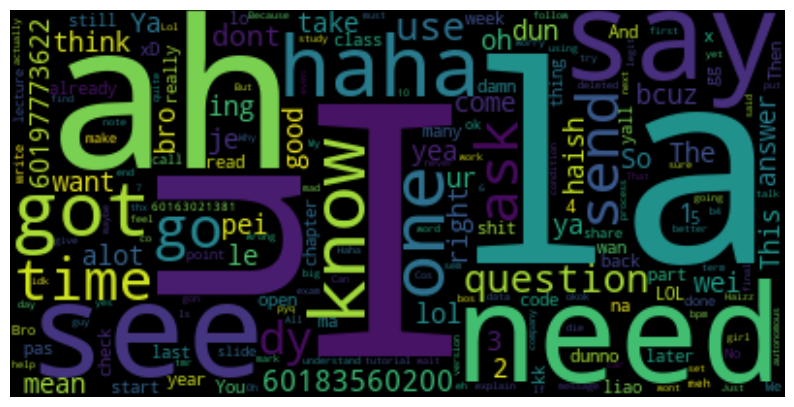

In [188]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axis
plt.show()


### Topic visualizations


Word Clouds for LDA:


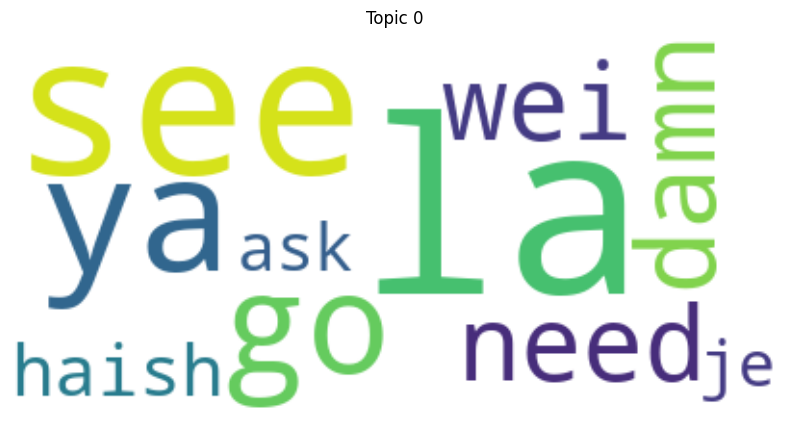

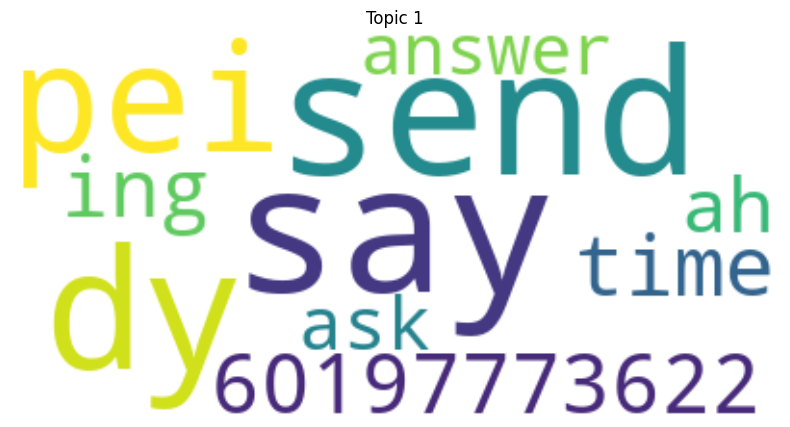

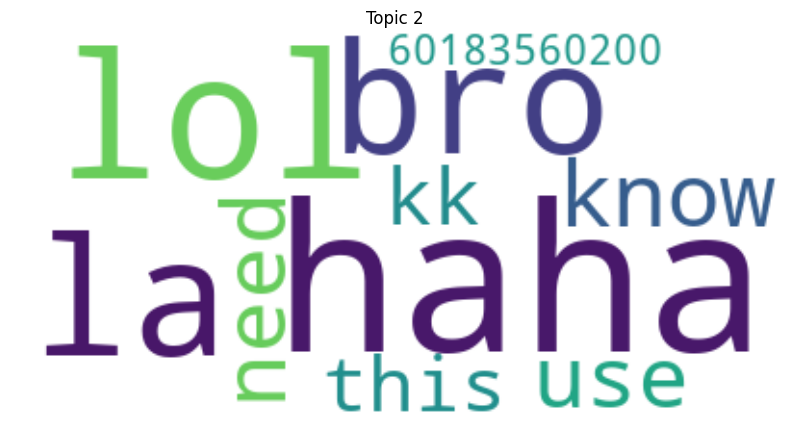

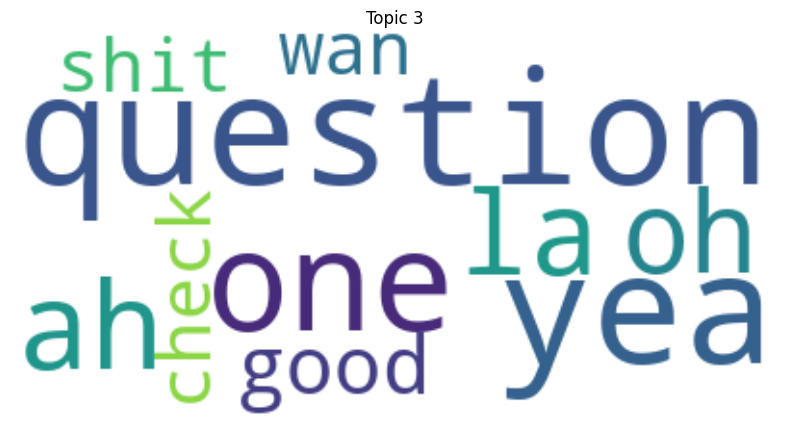

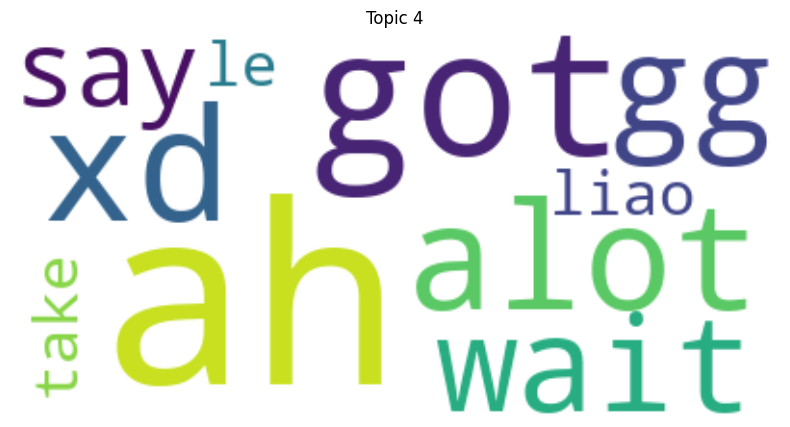


Word Clouds for NMF:


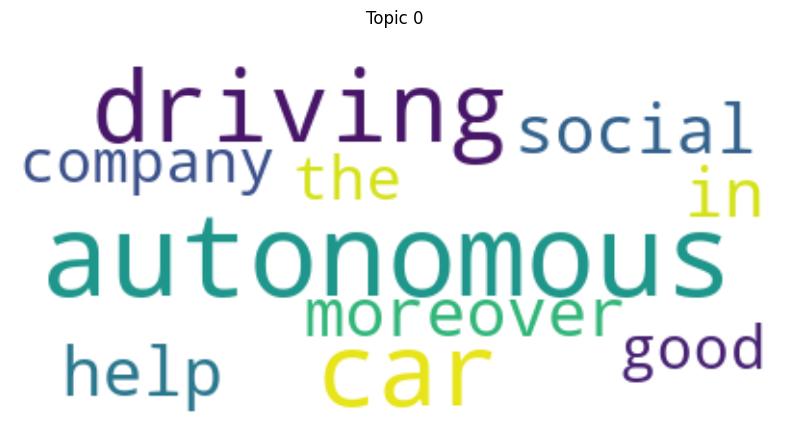

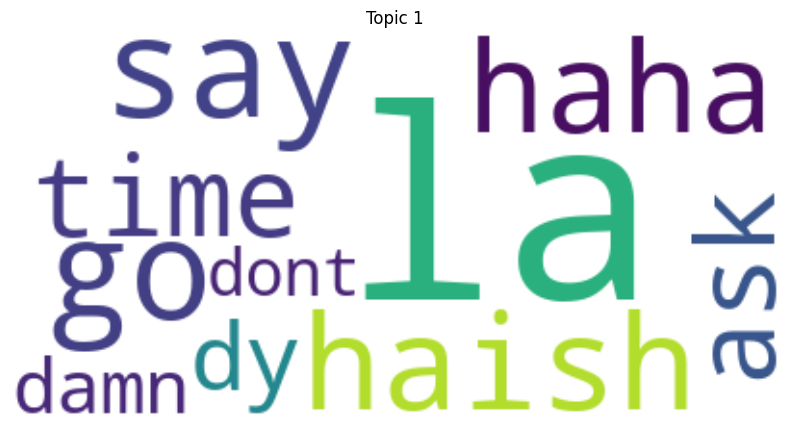

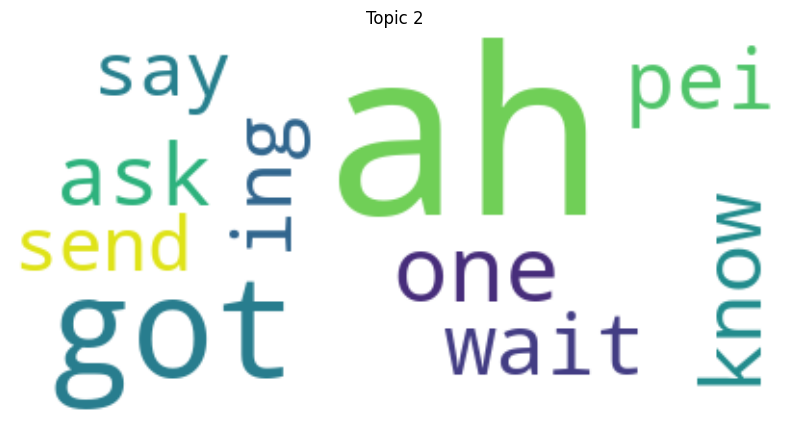

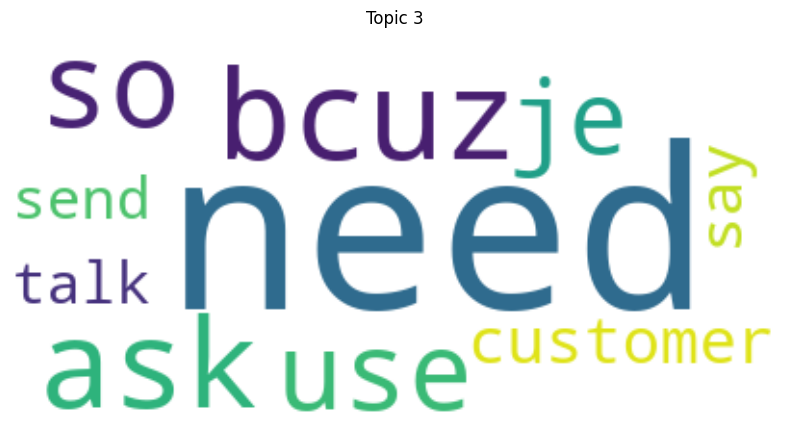

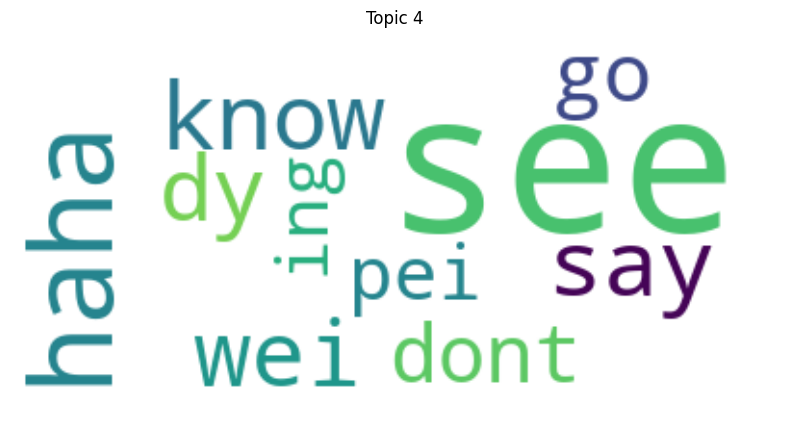


Word Clouds for pLSA:


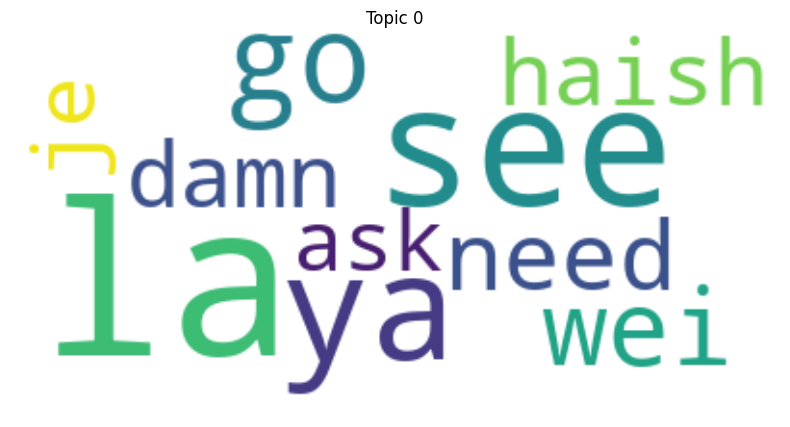

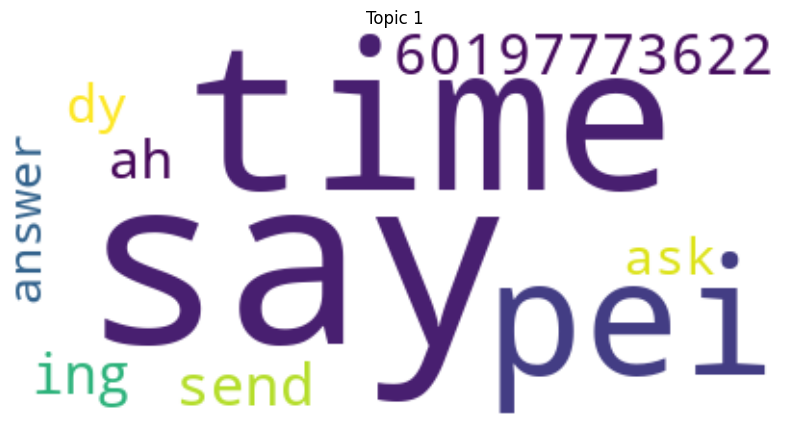

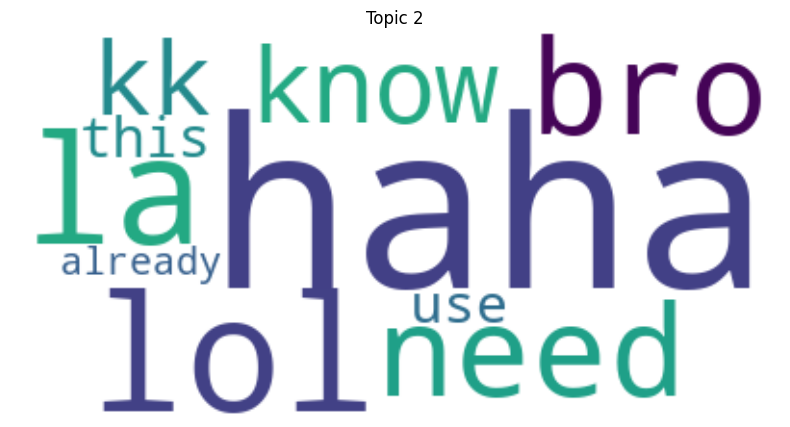

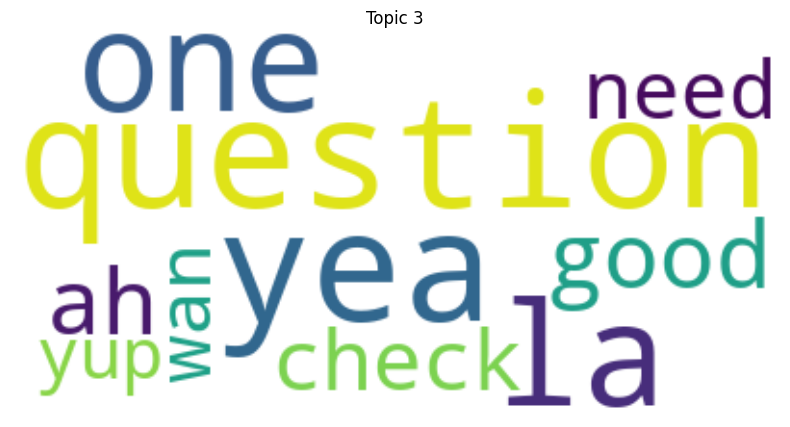

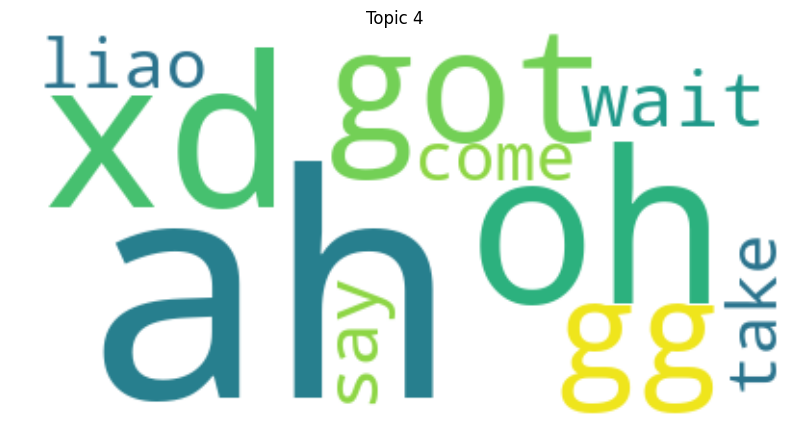


Word Clouds for LSA:


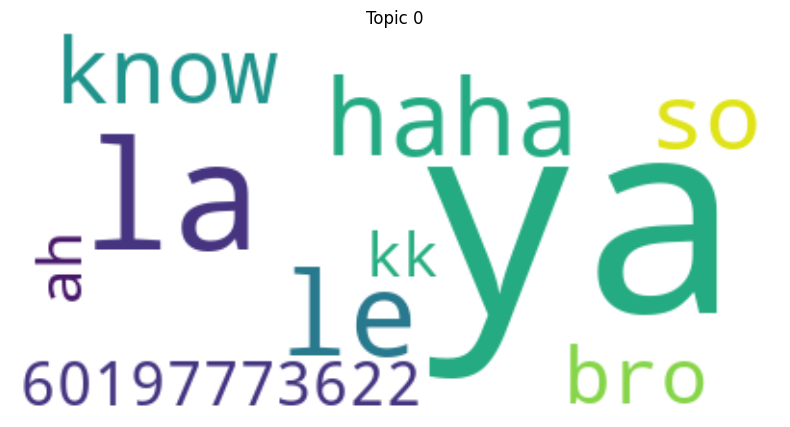

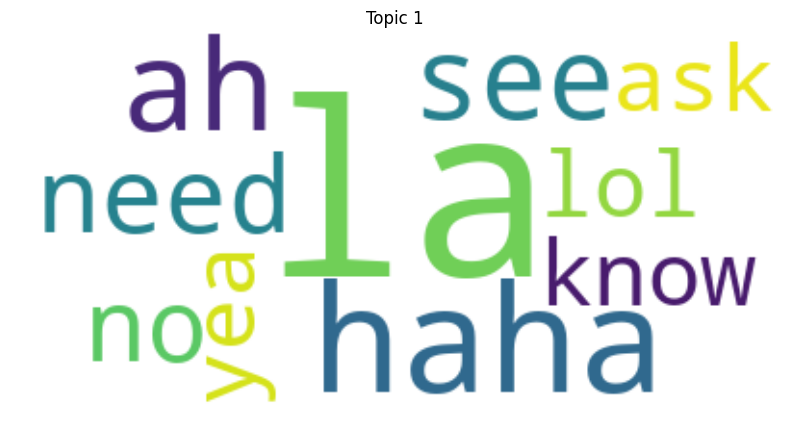

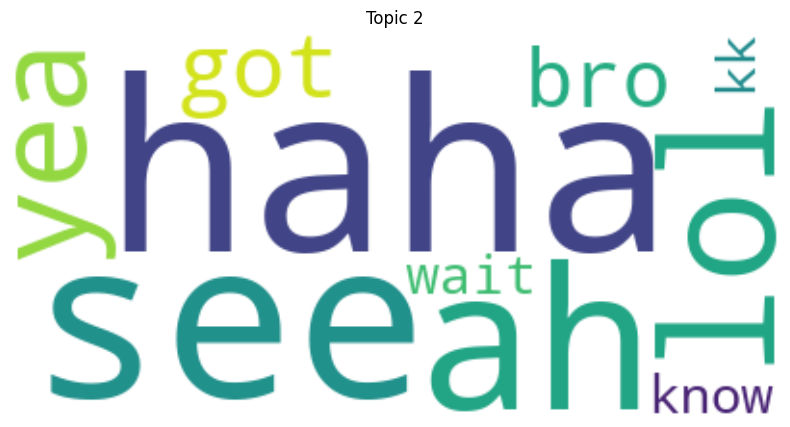

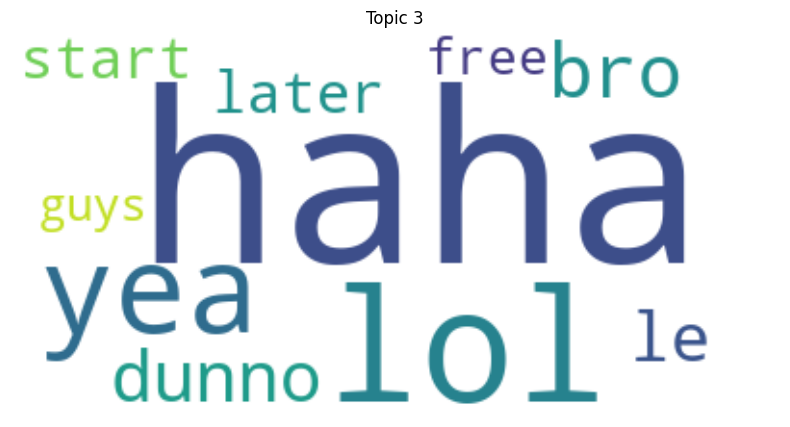

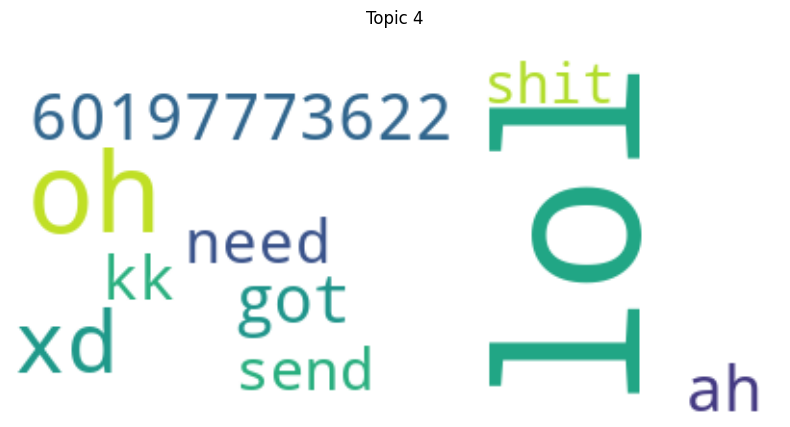


Bar Charts for LDA:


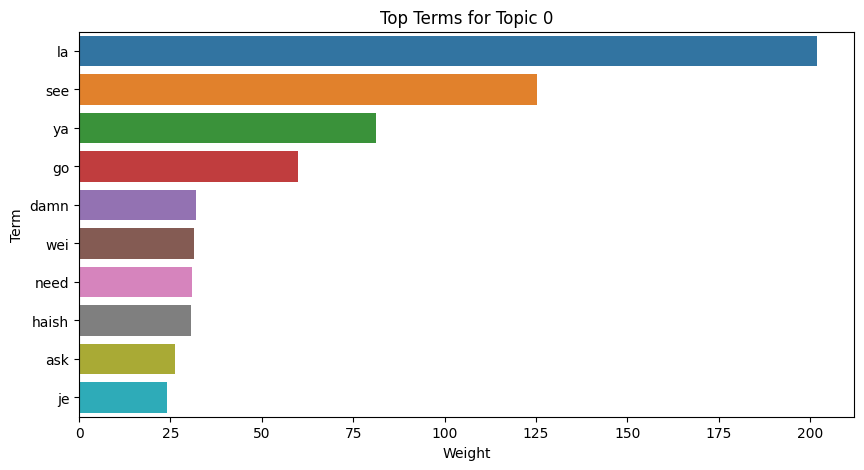

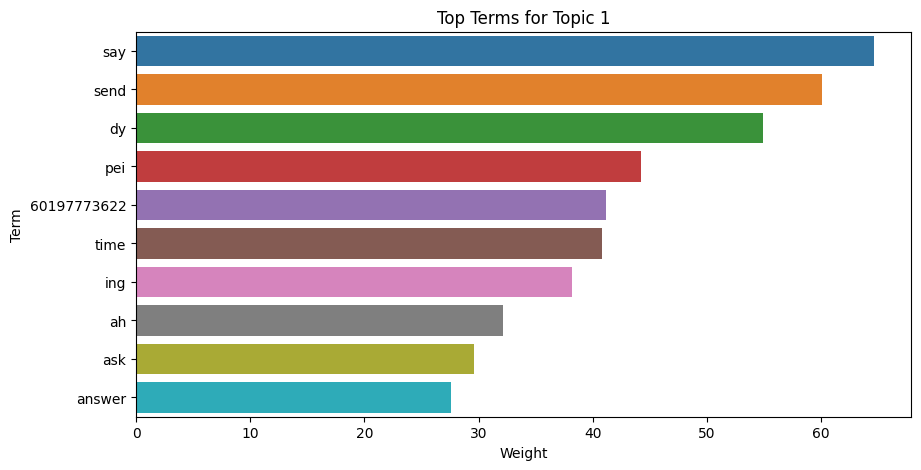

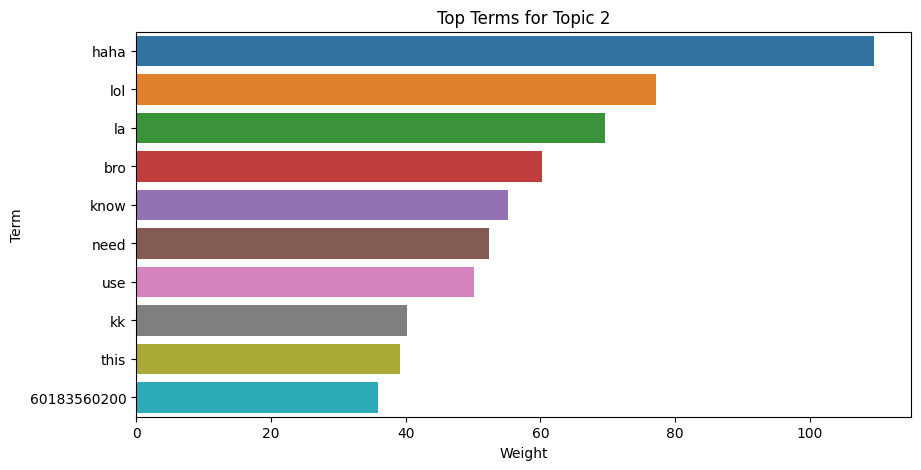

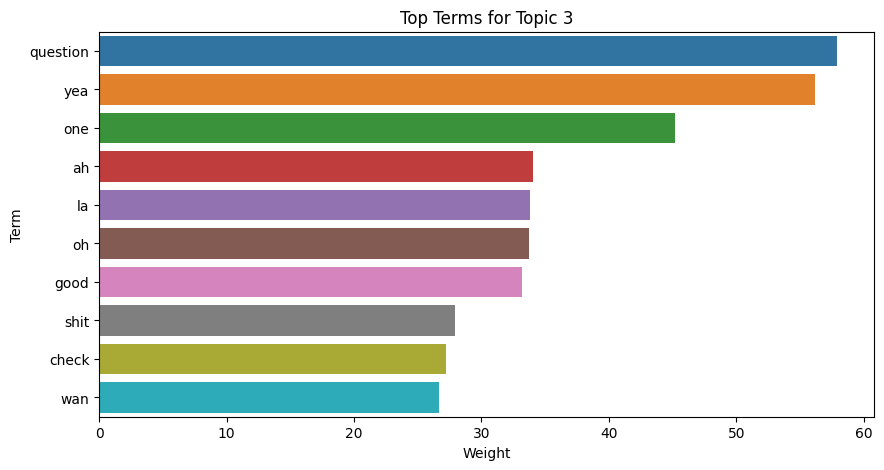

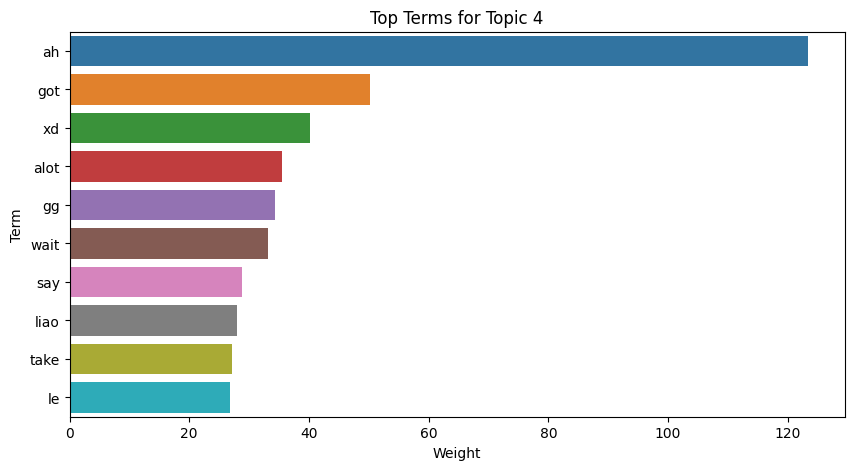


Bar Charts for NMF:


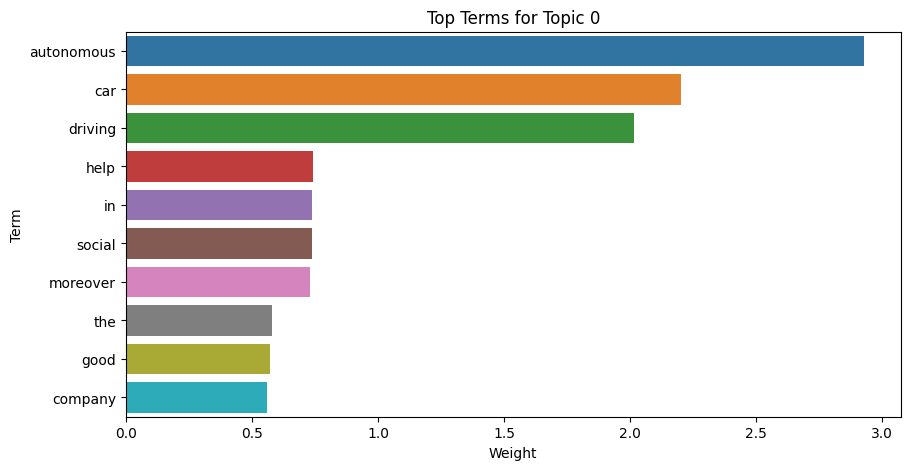

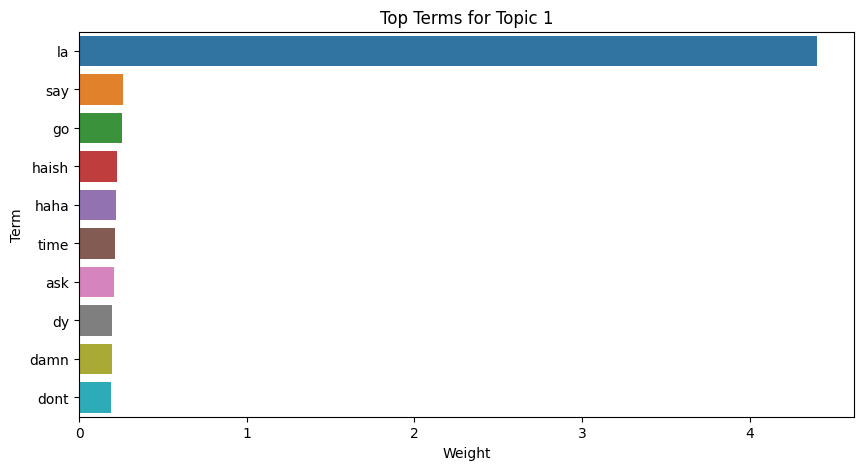

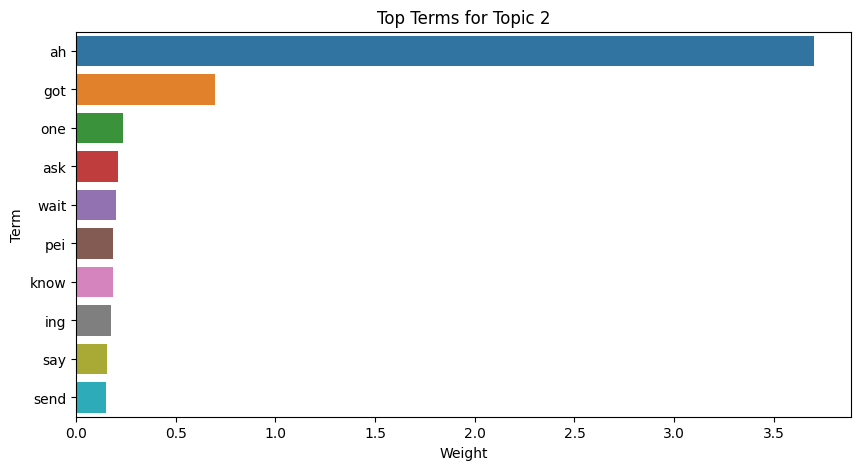

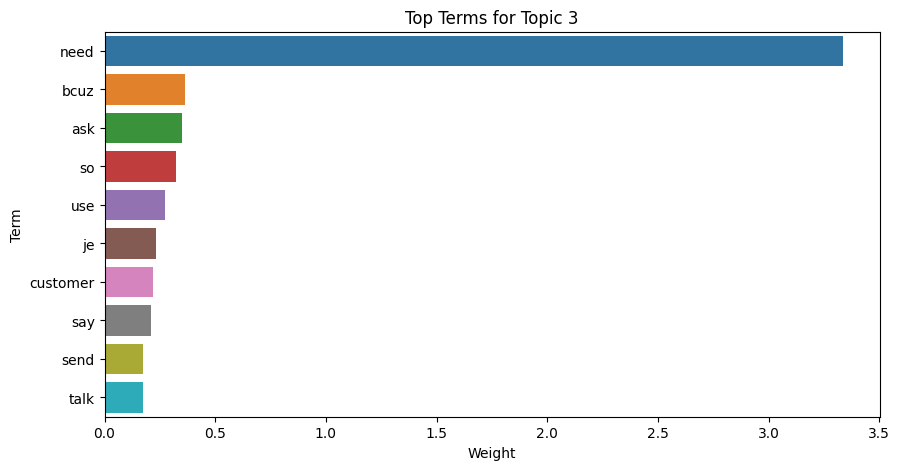

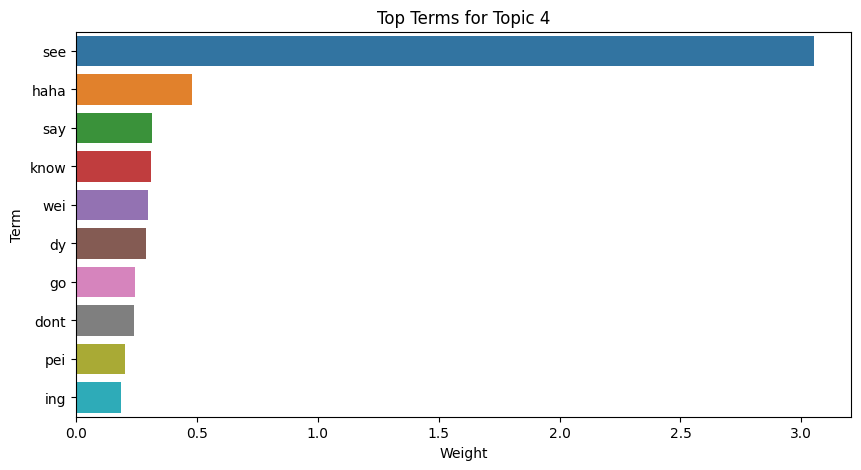


Bar Charts for pLSA:


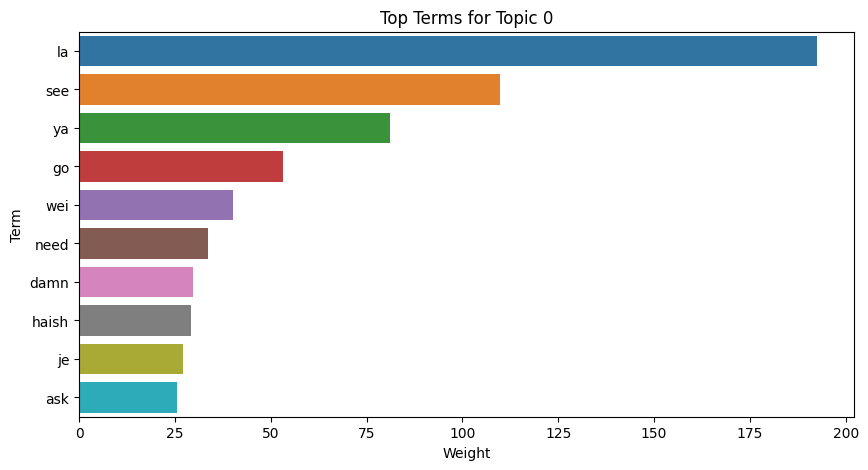

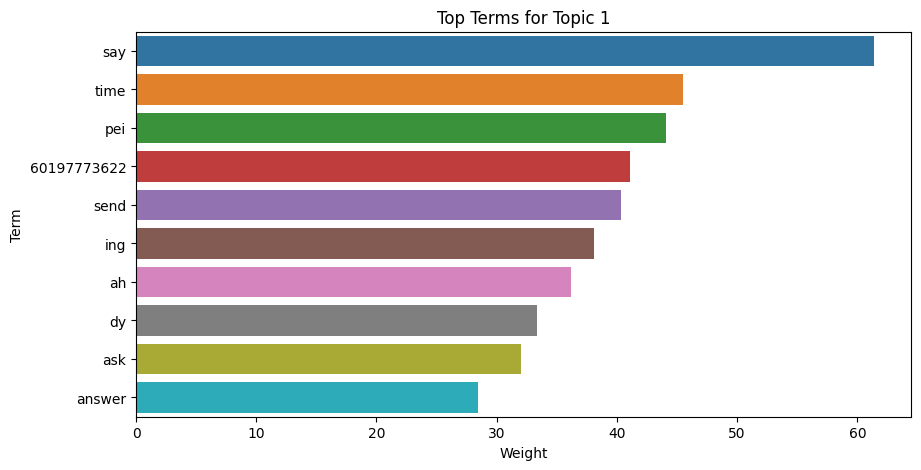

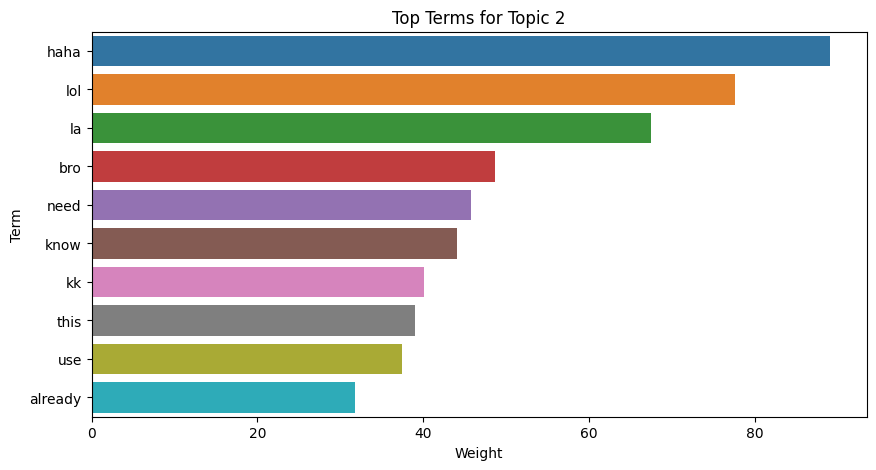

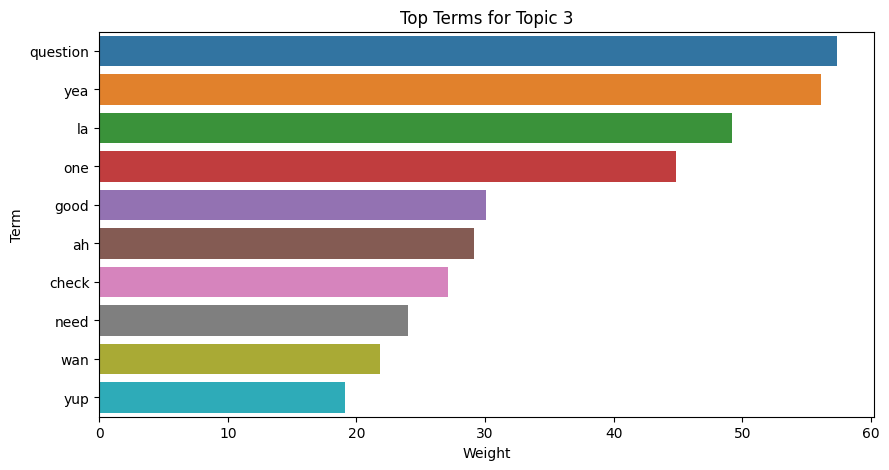

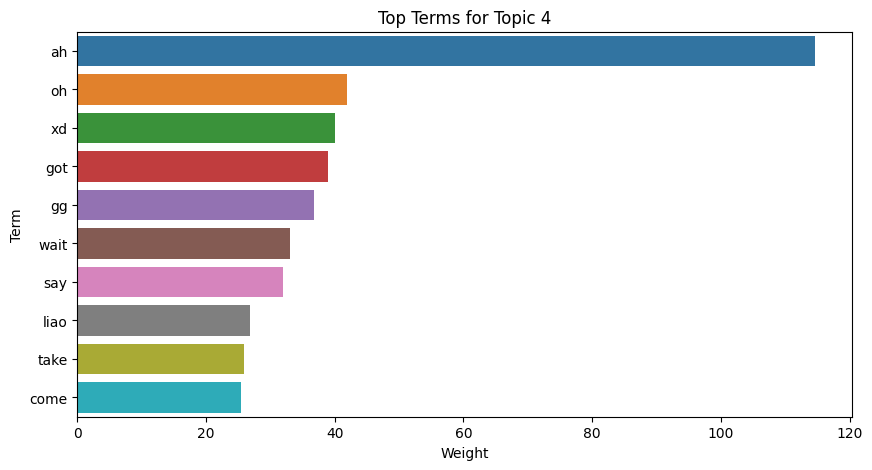


Bar Charts for LSA:


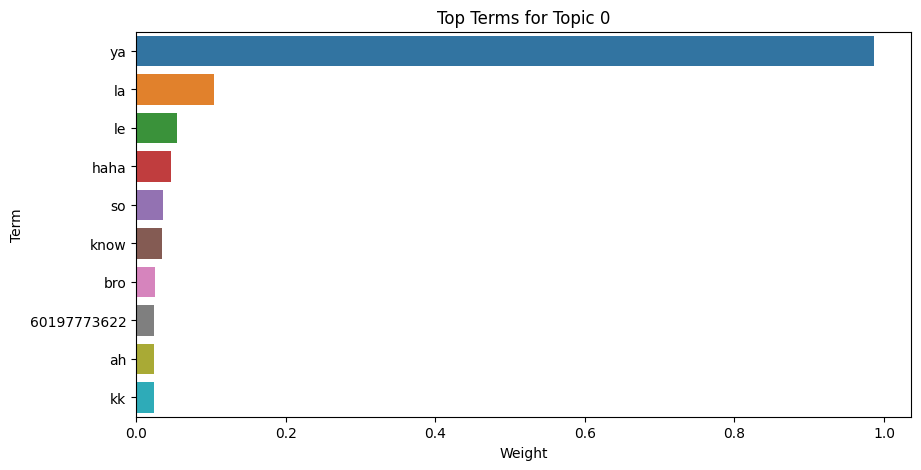

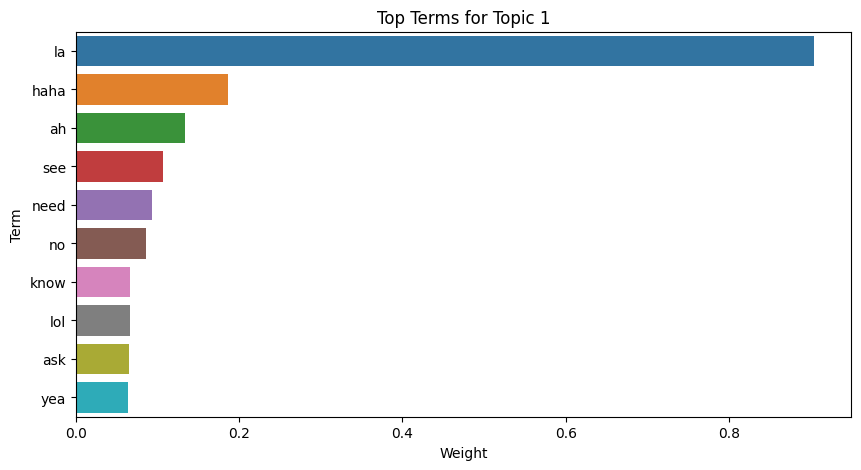

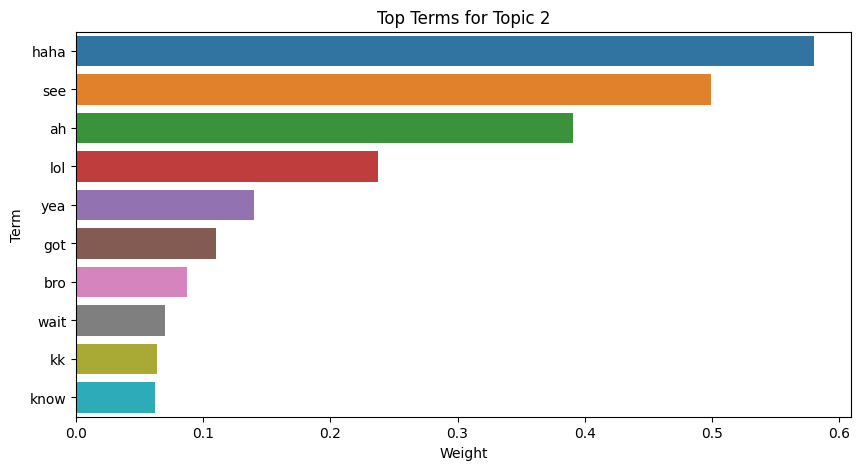

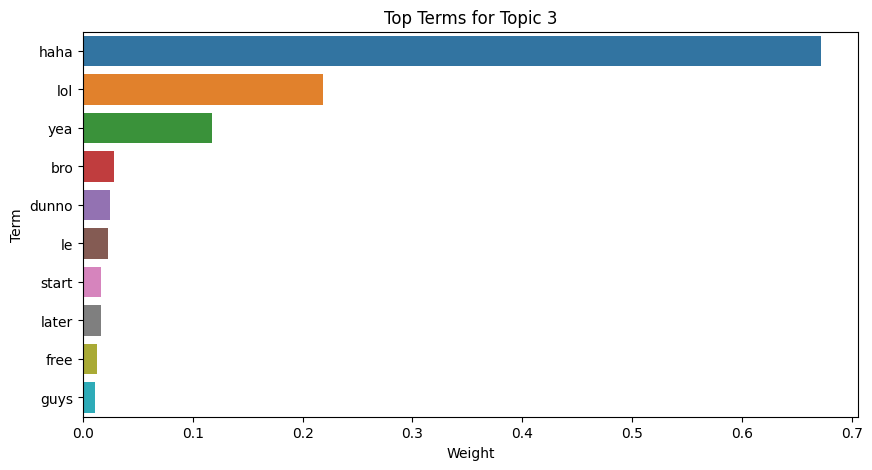

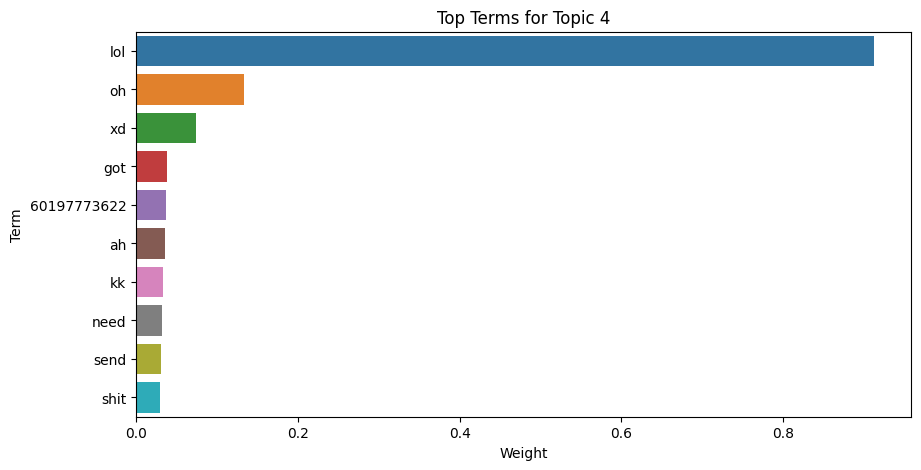

In [189]:
num_topics = 5

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(data['Tokenized_mgs'])

# Create a Document-Term Matrix using CountVectorizer for LDA
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(data["Tokenized_mgs"])

# Create Word Clouds
def create_word_cloud(model, vectorizer, num_topics):
    terms = vectorizer.get_feature_names_out()
    for idx, component in enumerate(model.components_):
        word_freq = {terms[i]: component[i] for i in component.argsort()[:-11:-1]}
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {idx}")
        plt.show()

print("\nWord Clouds for LDA:")
create_word_cloud(lda_model, count_vectorizer, num_topics)

print("\nWord Clouds for NMF:")
create_word_cloud(nmf_model, vectorizer, num_topics)

print("\nWord Clouds for pLSA:")
create_word_cloud(plsa_model, count_vectorizer, num_topics)

print("\nWord Clouds for LSA:")
create_word_cloud(lsa_model, vectorizer, num_topics)

# Create Bar Charts
def create_bar_chart(model, vectorizer, num_topics, top_n=10):
    terms = vectorizer.get_feature_names_out()
    for idx, component in enumerate(model.components_):
        top_terms = [(terms[i], component[i]) for i in component.argsort()[:-top_n - 1:-1]]
        df_top_terms = pd.DataFrame(top_terms, columns=['Term', 'Weight'])
        plt.figure(figsize=(10, 5))
        sns.barplot(x='Weight', y='Term', data=df_top_terms)
        plt.title(f"Top Terms for Topic {idx}")
        plt.show()

print("\nBar Charts for LDA:")
create_bar_chart(lda_model, count_vectorizer, num_topics)

print("\nBar Charts for NMF:")
create_bar_chart(nmf_model, vectorizer, num_topics)

print("\nBar Charts for pLSA:")
create_bar_chart(plsa_model, count_vectorizer, num_topics)

print("\nBar Charts for LSA:")
create_bar_chart(lsa_model, vectorizer, num_topics)


### Visualizing sentiments over time 

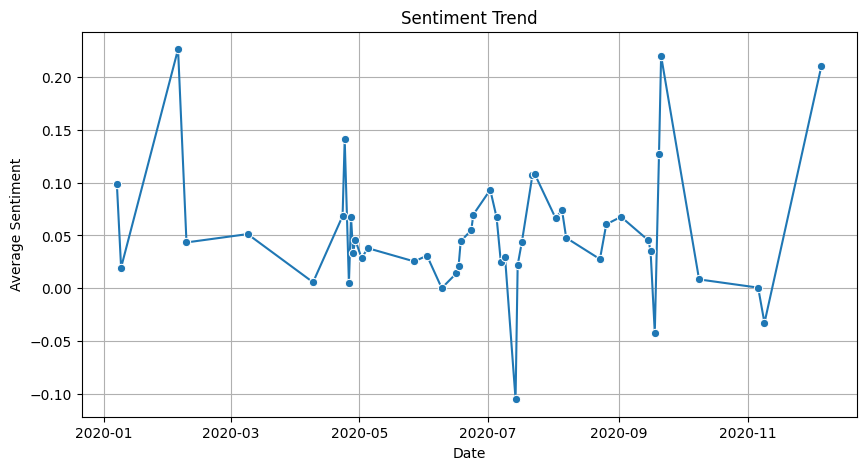

In [190]:
sid = SentimentIntensityAnalyzer()

# Analyze sentiment
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

data['sentiment_compound'] = data['Tokenized_mgs'].apply(get_sentiment)

# Aggregate sentiment scores by date
data["Date"] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.date
daily_sentiment = data.groupby('Date')['sentiment_compound'].mean().reset_index()

# Plot sentiment trends
plt.figure(figsize=(10, 5))
sns.lineplot(data=daily_sentiment, x='Date', y='sentiment_compound', marker='o')
plt.title('Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()

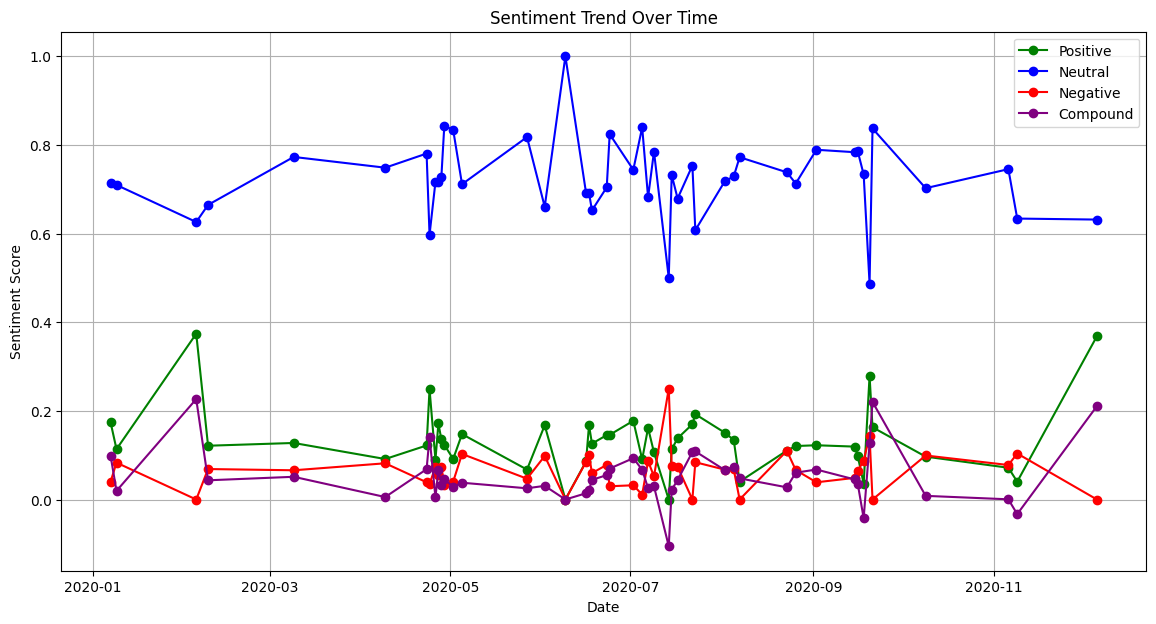

In [191]:
def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment

sentiments = data['Tokenized_mgs'].apply(get_sentiment)
df = pd.concat([data, sentiments.apply(pd.Series)], axis=1)

# Aggregate sentiment scores by date
data["Date"] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.date
daily_sentiment = df.groupby('Date')[['pos', 'neu', 'neg', 'compound']].mean().reset_index()

# Plot sentiment trends
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment['Date'], daily_sentiment['pos'], marker='o', label='Positive', color='green')
plt.plot(daily_sentiment['Date'], daily_sentiment['neu'], marker='o', label='Neutral', color='blue')
plt.plot(daily_sentiment['Date'], daily_sentiment['neg'], marker='o', label='Negative', color='red')
plt.plot(daily_sentiment['Date'], daily_sentiment['compound'], marker='o', label='Compound', color='purple')
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

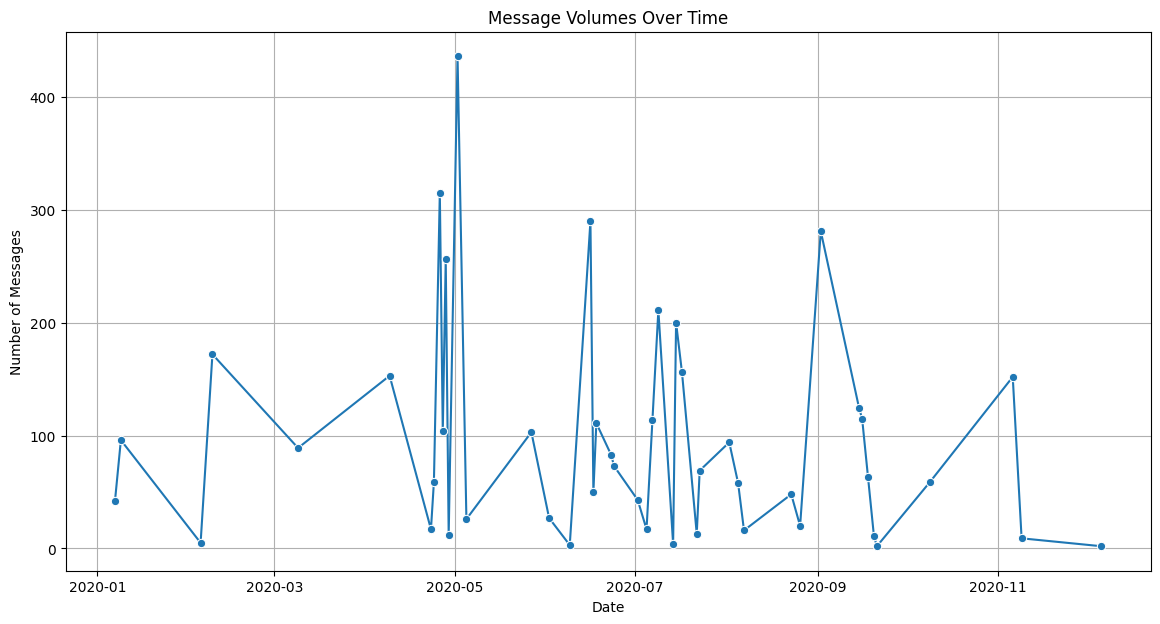

In [192]:
message_counts = data.groupby('Date').size().reset_index(name='Message Count')

# Plot message volumes over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=message_counts, x='Date', y='Message Count', marker='o')
plt.title('Message Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.grid(True)
plt.show()